In [1]:
!pip install librosa --upgrade
# ov = [] 
# while True:
#     ov.append(1)
!python3 --version

     |████████████████████████████████| 1.6MB 4.6MB/s 
  Created wheel for librosa: filename=librosa-0.7.2-cp36-none-any.whl size=1612885 sha256=ffe5bdc1d6de8204ae065ae9e1852d662c39bdb48fbede0827473e0ab402ed8c
  Stored in directory: /root/.cache/pip/wheels/4c/6e/d7/bb93911540d2d1e44d690a1561871e5b6af82b69e80938abef
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3
Python 3.6.9


In [2]:

import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np 
import scipy
# import mir_eval
import seaborn
from librosa import * 
import librosa.display
import librosa
import math
import sklearn
from scipy.stats import iqr
import os
import pandas as pd
from os import listdir
from os.path import isfile, join

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.mixture import GaussianMixture as GMM
from sklearn.gaussian_process import GaussianProcessRegressor as GMMRegressor
from sklearn.gaussian_process.kernels import RBF,DotProduct,Matern, WhiteKernel, ConstantKernel
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from google.colab import drive
drive.mount('/content/gdrive')

print(librosa.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
0.7.2


In [0]:

label_emotion = {
    1 : "Neutral",
    2 : "Calm",
    3 : "Happy",
    4 : "Sad",
    5 : "Angry",
    6 : "Fearful",
    7 : "Disgust",
    8 : "Surprised"
}
color = [
    'dimgray'
    ,'aqua'
    ,'mediumspringgreen'
    ,'royalblue'
    ,'red'
    ,'darkorange'
    ,'megenta'
    ,'yellow'
]
#google drive mounted
projectdir = "/content/gdrive/My Drive/ver/"
# Loca path
# projectdir = ""

savee_path = projectdir+"dataset/SAVEE/"
ravdess_path = projectdir+"dataset/RAVDESS/"
# Ravdess actor: odd number is Male, Even number is female
ravdess_actor_m = ['Actor_01','Actor_03','Actor_05','Actor_07','Actor_09','Actor_11','Actor_13','Actor_15','Actor_17']
ravdess_actor_f = ['Actor_08','Actor_10','Actor_12','Actor_14','Actor_16','Actor_18','Actor_20','Actor_22','Actor_24']

ravdess_actor =  ravdess_actor_m 

ravdess_actor_test_m = ['Actor_19','Actor_21','Actor_23']
ravdess_actor_test_f = ['Actor_02','Actor_04','Actor_06']
ravdess_actor_test = ravdess_actor_test_m 

NUMFEATURE = 80
N_MFCC = 60
# N_MFCC = 40
HOPLENGTH = 512
SAMPLINGRATE = 16000

In [0]:
# Pass in array, return


def findInnerQuartile(input_list):    
    center = 0
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        center = int(middle - .5)
    else:
        center = int(middle) 
    return center-int(NUMFEATURE/2) , center+ int(NUMFEATURE/2)

def scaleFeature(feature):
    x = StandardScaler().fit_transform(feature)
    # x = preprocessing.normalize(feature)
    return x

def featureReduction_PCA(data,n_comp=1):
    pca = PCA(n_components=n_comp)
    data = scaleFeature(data)
    x = pca.fit_transform(data)
    return np.array(x)

def featureReduction_TSNE(data,n_comp=2):
    x = StandardScaler().fit_transform(data)
    x = pd.DataFrame(x)
    
    tsne = TSNE(n_components=n_comp)
    x_tsne = tsne.fit_transform(x)
    
    return np.array(x_tsne[0])

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

def ndarrayToFeatureVector(array):
    featureVector = []
    i=0
    while i < len(array[0]):
        avg = 0
        column = []
        for subarray in array:
            column.extend([subarray[i]])
        avg = np.mean(column)
        featureVector.extend([avg])
        i+=1
    return featureVector

def generateGeneralComponent(directory,file):
    y , sr = librosa.load(directory+file,sr=SAMPLINGRATE)
    
    #Data extraction
    rms = librosa.feature.rms(y=y) # rms  1 x 140 
    rms_delta = librosa.feature.delta(rms,order=1)#  rms delta 1 x 140
    rms_delta2 = librosa.feature.delta(rms,order=2)

    crossing_rate = librosa.feature.zero_crossing_rate(y=y) # crossing_rate  1 x 140
    crz_d = librosa.feature.delta(crossing_rate,order=1)

    chroma_mean = np.abs(np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T,axis=0))

    MFCC = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=N_MFCC)
    mfcc_mean = np.mean(MFCC.T, axis=0)
    mfcc_delta = np.abs(librosa.feature.delta(MFCC,order=1))
    mfcc_delta2 = np.abs(librosa.feature.delta(MFCC,order=2))

    STFT = np.abs(librosa.stft(y=y))
    stft_delta = librosa.feature.delta(STFT,order=1)

    mel_mean = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T,axis=0)

    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=HOPLENGTH)

    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=HOPLENGTH)

    # lpc = librosa.lpc(y,27)
    # lpc_delta = librosa.feature.delta(lpc,order=1)

    result = np.array([a*c for a,c in zip(rms_delta[0], crossing_rate[0])])

    #Data reduction/scaling - return 1D vector
    mfcc_result = featureReduction_PCA(MFCC).T[0]  # 140 x 1
    mfcc_delta = featureReduction_PCA(mfcc_delta).T[0] # 140 x 1
    mfcc_delta2 = featureReduction_PCA(mfcc_delta2).T[0] # 140 x 1
  
    rms = featureReduction_PCA(rms[0].reshape(-1,1)).T[0]
    rms_delta = featureReduction_PCA(rms_delta[0].reshape(-1,1)).T[0]
    rms_delta2 = featureReduction_PCA(rms_delta2[0].reshape(-1,1)).T[0]

    stft = featureReduction_PCA(STFT).T[0]
    stft_delta = featureReduction_PCA(stft_delta).T[0]

    mel_mean = featureReduction_PCA(mel_mean.reshape(-1,1)).T[0]

    crossing_rate = featureReduction_PCA(crossing_rate.reshape(-1,1),1).T[0]
    crz_d = featureReduction_PCA(crz_d.reshape(-1,1),1).T[0]

    chroma_mean = featureReduction_PCA(chroma_mean.reshape(-1,1)).T[0] 

    tempogram = featureReduction_PCA(tempogram).T[0] 

    # lpcpca = featureReduction_PCA(lpc.reshape(-1,1)).T[0]
    # lpc_delta = featureReduction_PCA(lpc_delta.reshape(-1,1)).T[0]
    #Data selection
    p25 , p75 = findInnerQuartile(result)
    featurevector = result[p25: p75]

    p25 , p75 = findInnerQuartile(rms)
    rmsv = rms[p25:p75]

    p25 , p75 = findInnerQuartile(rms_delta)
    rmsDELTA = rms_delta[p25:p75]

    p25,p75 = findInnerQuartile(rms_delta2)
    rmsDELTA2 = rms_delta2[p25:p75]

    p25,p75 = findInnerQuartile(stft)
    stft = stft[p25:p75]

    p25,p75 = findInnerQuartile(stft_delta)
    stft_delta = stft_delta[p25:p75]

    p25 , p75 = findInnerQuartile(mfcc_result)
    mfccv = mfcc_result[p25:p75]

    mfcc_mean = mfcc_mean

    p25 , p75 = findInnerQuartile(mfcc_delta)
    mfcc_deltav = mfcc_delta[p25:p75]

    p25 , p75 = findInnerQuartile(mfcc_delta2)
    mfcc_delta2v = mfcc_delta2[p25:p75]
    
    p25 , p75 = findInnerQuartile(mel_mean)
    mel_mean  = mel_mean[p25:p75]

    p25 , p75 = findInnerQuartile(crossing_rate)
    cross = crossing_rate[p25:p75]

    p25 , p75 = findInnerQuartile(crz_d)
    crz_d = crz_d[p25:p75]

    p25 , p75 = findInnerQuartile(chroma_mean)
    chroma_mean = chroma_mean[p25:p75]

    p25 , p75 = findInnerQuartile(tempogram)
    tempogram = tempogram[p25:p75]

    component =  {'FEATUREV' : featurevector
                    , 'STFT' : stft
                   , 'STFTD' : stft_delta
                     , 'LPC' : []
                     , 'LPCD' : []
                    , 'MFCC' : mfccv
                    , 'TEMPO': tempogram
                 , 'MFCCMEAN': mfcc_mean
                   , 'MFCCD' : mfcc_deltav
                  , 'MFCCDD' : mfcc_delta2v
               , 'ZEROCROSS' : cross
                   , 'ZCRD' : crz_d
                     , 'RMS' : rmsv
                    , 'RMSD' : rmsDELTA
                    , 'RMSDD': rmsDELTA2
                  , 'CHROMA' : chroma_mean
                 , 'MELMEAN' : mel_mean}
    
    return component

def createSAVEEComponent(directory,file):
    index = SAVEE_emoIndex[file[0:-6]]
    emotionv = [0,0,0,0,0,0,0,0]
    emotionv[index - 1] = 1
    emotionl = index - 1
    
    component = generateGeneralComponent(directory,file)
    component['LABELV'] = emotionv
    component['EMOTIONL'] = emotionl
    return component
 
def createRAVDESSComponent(directory,file):
    file_feature = file.split("-")
    emotionv = [0,0,0,0,0,0,0,0]
    emotionindex = int(file_feature[2])-1
    emotionl = emotionindex
    emotionv[emotionindex] = 1
    
    component = generateGeneralComponent(directory,file)
    component['LABELV'] = emotionv
    component['EMOTIONL'] = emotionl
    return component
    
    
def findEmotionIndex(vector):
    index = 1 
    for column in vector:
        if int(column) == 1:
            return index
        index = index + 1
    return 1

def findValueByKey(pool,key):
    for skey,value in pool.items():
        if skey == key:
            return value
    return 99
        
def combine(*arg):
    big = np.array([])
    for arr in arg:
        big = np.append(big,arr)
    return big


In [5]:
# Load train data
data = [dict() for x in range(8)]
files_RAVDESS = []
for actor in ravdess_actor:
    actorpath = ravdess_path + actor 
    files = (os.listdir(actorpath))
    for file in files:
      files_RAVDESS.append((actorpath,file))

# Load test data
testdata = [dict() for x in range(8)]
files_RAVDESS_test = []
for actor in ravdess_actor_test:
    actorpath = ravdess_path + actor 
    files = (os.listdir(actorpath))
    for file in files:
      files_RAVDESS_test.append((actorpath,file))

# Create component for train data
n_file = 0
for path,file in files_RAVDESS:
    component = createRAVDESSComponent(path + '/',file)
    data[int(component['EMOTIONL'])][file] = component
    n_file +=1

# Create component for test data
n_testfile = 0
for path,file in files_RAVDESS_test :
    component = createRAVDESSComponent(path + '/',file)
    testdata[int(component['EMOTIONL'])][file] = component
    n_testfile +=1


print('All dataset imported')
print('Total train data : {0}'.format(n_file))
print('Total test data : {0}'.format(n_testfile))


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel 

All dataset imported
Total train data : 540
Total test data : 180


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


In [0]:
# Serialize list
import pickle 
pickle.dump(data, open('trainaudiomale.p', 'wb')) 
pickle.dump(testdata, open('testaudiomale.p', 'wb')) 


In [7]:
# Load serialized list
#  - Only run when extraction parameter change made.
#  - Or  when change is use actor.
data = pickle.load(open('trainaudiomale.p', 'rb'))
traindata = pickle.load(open('testaudiomale.p', 'rb'))
print('Loaded')

Loaded


In [8]:

# label_emotion = {
#     1 : "Neutral",  - 0
#     2 : "Calm",     - 1
#     3 : "Happy",    - 2
#     4 : "Sad",      - 3
#     5 : "Angry",    - 4
#     6 : "Fearful",   -5
#     7 : "Disgust",  - 6
#     8 : "Surprised" - 7
# }


lst = []
trainedprocessed = []
# Prepare train data 
# choosenemotion = [2,3,4,7]
choosenemotion = [0,2,3]
for x in choosenemotion:
  filenum = 0
  for readfile, component in data[x].items():
        featurevector = combine( component['ZEROCROSS'],component['MFCCMEAN'], component['RMSD'])
        lst.append((featurevector,component['LABELV']))
        trainedprocessed.append((file,component['LABELV']))
        filenum += 1
  print('Train : {0}:{1}'.format(label_emotion.get(x+1),filenum))


testlst=[]
for x in choosenemotion:
  testfilenum = 0
  for readfile, component in testdata[x].items():
        featurevector = combine( component['ZEROCROSS'],component['MFCCMEAN'], component['RMSD'])
        testlst.append((featurevector,component['LABELV']))
        testfilenum += 1
  print('Test : {0}:{1}'.format(label_emotion.get(x+1),testfilenum))


print('Total train data : {0}'.format(len(lst)))
print('Total test data : {0}'.format(len(testlst)))

Train : Neutral:36
Train : Happy:72
Train : Sad:72
Test : Neutral:12
Test : Happy:24
Test : Sad:24
Total train data : 180
Total test data : 60


In [0]:
from sklearn.svm import SVC
from sklearn.svm import SVR 
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

def getOptimisedParameter(training_x,training_y):
    y_converted = []
    for label in training_y:
        y_converted.append(findEmotionIndex(label))

    index = 0
    importantIndex = []

    # model = SVC(kernel='linear', C=16)
    # model = model.fit(training_x, y_converted)
    # sel = SelectFromModel(model, threshold=0.6,prefit=True)



    # for entry in sel.get_support():
    #   if entry == True:
    #     importantIndex.append(index)
    #   index +=1
#  112 k_feature --> 67%
    regressor = SVR(kernel='linear', C=1)
    sffs = SFS(regressor, 
           k_features=112, 
           forward=True, 
           floating=True, 
           scoring='accuracy')
    sffs = sffs.fit(training_x, training_y)
    importantIndex = sffs.k_feature_idx_

    # rfe = RFE(estimator=regressor,n_features_to_select=90)
    # rfe = rfe.fit(training_x, y_converted)

    # model = ExtraTreesClassifier()
    # model.fit(training_x,training_y)
    # # print(model.feature_importances_)
    # for entry in model.feature_importances_:
    #   if entry > 0.0055:
    #     importantIndex.append(index)
    #   index +=1

    # estimator =SVC(kernel='linear',C=1,probability=True) #59%
    # model = RFECV(estimator=estimator, step=1, cv=3, scoring='balanced_accuracy')
    # model.fit(training_x, y_converted)

    # index = 0
    # importantIndex = []
    # for entry in model.support_:
    #   if entry == True:
    #     importantIndex.append(index)
    #   index +=1

    print('Number of feature : {0}'.format(len(importantIndex)))
    return len(importantIndex),importantIndex

def getOptimisedFeature(features,importantIndex):
    optimized = []
    for index in importantIndex:
        optimized.append(features[index])
    return np.asarray(optimized)

def optimizeFeatureData(data,importantIndex):
    optimizedDataset = []
    
    for entry in data:
        optimizedDataset.append(getOptimisedFeature(entry,importantIndex))
    return np.asarray(optimizedDataset)

def OptimiseDataSet(X,y,xtest=[],ytest=[]):
    if len(xtest) == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    else:
        X_train = X
        y_train =  y
        X_test =  xtest  
        y_test = ytest

    OPTNUMFEATURE, selectedindex = getOptimisedParameter(X_train,y_train)
    X_train = optimizeFeatureData(X_train,selectedindex)
    X_test = optimizeFeatureData(X_test,selectedindex)
    print('Number of selected feature : {0}'.format(OPTNUMFEATURE))
    return X_train, X_test, y_train, y_test , OPTNUMFEATURE, selectedindex
    

In [10]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)
print(X.shape)


Xtest, ytest = zip(*testlst)
Xtest = np.asarray(Xtest)
ytest = np.asarray(ytest)

FVECTOR_SIZE = len(X[0])

X_train, X_test, y_train, y_test, nfeature, selectedindex = OptimiseDataSet(X, y,Xtest,ytest)


(180, 220)


Streaming output truncated to the last 5000 lines.
ValueError: bad input shape (144, 8)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (144, 8)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (144, 8)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (144, 8)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:

Number of feature : 112
Number of selected feature : 112


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (144, 8)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (144, 8)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (144, 8)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will

In [11]:
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(nfeature)
print(selectedindex)
# selectedindex = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]

112
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111)


In [0]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score ,roc_curve, auc

y_converted = []
for label in y_train:
    y_converted.append(findEmotionIndex(label))


X_train, X_tunner, y_train_int, y_tunner = train_test_split(X_train, y_converted, test_size=0.2, random_state=0)


y_train = []
for label in y_train_int:
    emotionv = [0,0,0,0,0,0,0,0]
    emotionv[label-1] = 1
    y_train.append(emotionv) 


random_grid = {'C': [1,2,4,8,16,18,20,32,64,128,256,512,800],
               'kernel': ['linear','poly','rbf'],
               'shrinking': [True, False],
               'probability': [True],
               'tol' : [1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4],
               'max_iter': [-1],
               'decision_function_shape':['ovr']
               }
               
estimator =  SVC()
# svc_grid  = GridSearchCV(estimator = estimator
#                    , param_grid = random_grid
#                   , scoring='accuracy'
#                    , n_jobs=1
#                   ,  cv=5
#                   ,  iid=True
#                   ,  refit=True)
# svc_grid.fit(X_train, y_converted)
# bestparam = svc_grid.best_params_

rt_random  = RandomizedSearchCV(estimator=estimator
                   , param_distributions=random_grid
                   ,scoring='balanced_accuracy'
                   ,n_jobs=1
                   ,n_iter=500
                   ,cv=3)
rt_random.fit(X_tunner,y_tunner )
bestparam = rt_random.best_params_


In [13]:
print(bestparam)
# bestparam = {'tol': 0.0007, 'shrinking': True, 'probability': True, 'max_iter': -1, 'kernel': 'linear', 'decision_function_shape': 'ovr', 'C': 64}


{'tol': 0.0001, 'shrinking': True, 'probability': True, 'max_iter': -1, 'kernel': 'linear', 'decision_function_shape': 'ovr', 'C': 8}


In [14]:
y_train_index = []
for label in y_train:
    y_train_index.append(findEmotionIndex(label))

y_test_index = []
for label in y_test:
    # y_test_index.append(label)
    y_test_index.append(findEmotionIndex(label))


#  feed optimized hyperparameter calculated into the model
clf = SVC(**bestparam)
clf = clf.fit(X_train, y_train_index)
svc_acc = clf.score(X_test, y_test_index)
print('accuracy: {0}'.format(svc_acc))



accuracy: 0.7333333333333333


In [15]:
correct = 0
incorrect =0
unknown = 0
prediction = clf.predict(X_train)
for x in range(len(X_train)):
    # print('Entry #{0}'.format(x))
    actual = findEmotionIndex(y_train[x])
    # print('\t predicted : {0}'.format(prediction[x]))
    # print('\t actual : {0}'.format(actual))
    if (int(prediction[x]) == int(actual) ):
        correct += 1 
    else:
        incorrect += 1
print('Correct : {0}'.format(correct))
print('inCorrect : {0}'.format(incorrect))
acc = correct/(correct + incorrect)
print('Accuracy : {0} %'.format(round(acc*100)))


Correct : 144
inCorrect : 0
Accuracy : 100 %


In [16]:
#test svc - manual
correct = 0
incorrect =0
unknown = 0
predictions = clf.predict(X_test)
for x in range(len(predictions)):
    correctindex = findEmotionIndex(y_test[x])
    predicted = predictions[x]
    if (predicted == correctindex ):
        correct += 1 
    else:
        incorrect += 1

print('Correct : {0}'.format(correct))
print('inCorrect : {0}'.format(incorrect))
acc = correct/(correct + incorrect)
print('Accuracy : {0} %'.format(round(acc*100)))
    
    # 4 test actor - 55%

Correct : 44
inCorrect : 16
Accuracy : 73 %


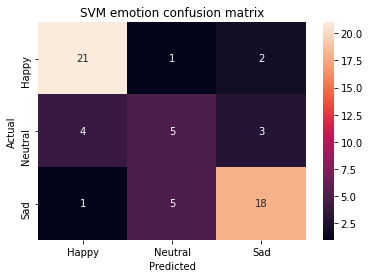

In [17]:
#Confusion matrix
predicted_emotion = []
for label in predictions:
    predicted_emotion.append(label_emotion.get(label))

true_emotion = []
for label in y_test:
    true_emotion.append(label_emotion.get(findEmotionIndex(label)))

emotions = [*label_emotion.values()]



confusion_matrix = pd.crosstab(pd.Series(true_emotion)
                               , pd.Series(predicted_emotion)
                               , rownames=['Actual']
                               , colnames=['Predicted']
                               )

ax = plt.axes()
seaborn.heatmap(confusion_matrix, ax = ax,annot=True)

ax.set_title('SVM emotion confusion matrix')
plt.show()